In [1]:
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fileName = '../../ETOPO1_Ice_c_gmt4.grd'

fh = Dataset(fileName, mode='r')

fh.variables.keys()

x = fh.variables['x']
y = fh.variables['y']
z = fh.variables['z']

In [3]:
x,y,z

(<class 'netCDF4._netCDF4.Variable'>
 float64 x(x)
     long_name: Longitude
     actual_range: [-180.  180.]
     units: degrees_east
 unlimited dimensions: 
 current shape = (21600,)
 filling off, <class 'netCDF4._netCDF4.Variable'>
 float64 y(y)
     long_name: Latitude
     actual_range: [-90.  90.]
     units: degrees_north
 unlimited dimensions: 
 current shape = (10800,)
 filling off, <class 'netCDF4._netCDF4.Variable'>
 int32 z(y, x)
     long_name: z
     _FillValue: -2147483648
     actual_range: [-10803.   8333.]
 unlimited dimensions: 
 current shape = (10800, 21600)
 filling off)

In [4]:
dx = np.diff(x[:])[0]
dy = np.diff(y[:])[0]
print('dx={}, dy={}'.format(dx,dy))

dx=0.01666666666667993, dy=0.01666666666666572


I want the rectangle $ (lon,lat) \in [-240,-120] \times [-60, 60] $, but can only use  $lon \in[-180,180]$, hence have to use the joined set: $$lon \in [120,180] \cup [-180,-120]$$

# Pick a subrectangle centered on the pacific 

In [5]:
y0 = -70
y1 = 70
j0 = int((y0+90)*60)
j1 = int((y1+90)*60)

(0.0, 108.0, 0.0, 168.0)

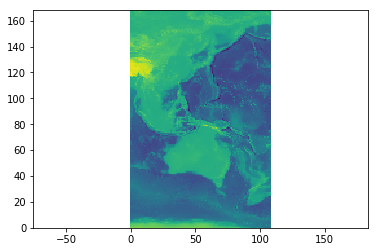

In [6]:
x0 = 90
x1 = 180
i0 = int((x0+180)*60)
i1 = int((x1+180)*60)

plt.pcolormesh(z[j0:j1:50,i0:i1:50])
plt.axis('equal')

(0.0, 132.0, 0.0, 168.0)

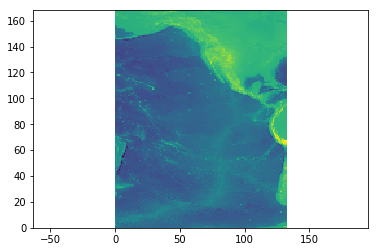

In [7]:
x2 = 290-360
i2 = int((x2+180)*60)

plt.pcolormesh(z[j0:j1:50,:i2:50])
plt.axis('equal')

In [8]:
x2

-70

Select bathymetry from range and skip some values

In [9]:
skip = 5*4
zfinal = np.hstack([z[j0:j1:skip,i0:i1:skip], z[j0:j1:skip,:i2:skip]])
print('Mesh size:', zfinal.shape)

Mesh size: (420, 600)


(0.0, 60.0, 0.0, 42.0)

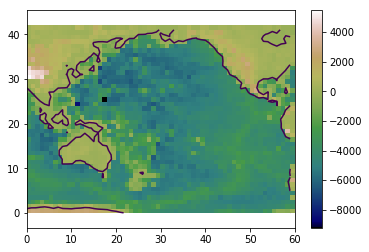

In [10]:
plt.pcolormesh(zfinal[::10,::10],cmap=plt.cm.gist_earth)
plt.colorbar()
plt.contour(zfinal[::10,::10],[0.0])
plt.axis('equal')

np.savetxt('bathymetry',-zfinal[::1,::1])

In [11]:
arr = np.hstack([zfinal.shape[0],zfinal.shape[1],(-zfinal).ravel()])

In [12]:
arr.astype('float64').tofile('bathymetry')
